<div style="background-color: #B7A6C9; padding:30px; border-radius:50px">
  <h1 style="color:#000000; text-align:center;">💰 Predicting Loan Payback 💰 </h1>
</div>

The goal of this notebook is to predict whether a borrower will pay back their loan or not depending on features like :
* Loan amount, interest rate, credit score...
* Gender, education level, employment status ... 

The submissions for this competition are evaluated using the area under the ROC curve:

<p style="text-align: center;">
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20230410164437/AUC-ROC-Curve.webp" alt="AUC-ROC Curve" width="500"/>
</p>


# 1. Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("colorblind")

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report


import warnings 
warnings.filterwarnings("ignore")

# 2. Loading Data

In [2]:
train_df=pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
test_df=pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")
ss_df=pd.read_csv("/kaggle/input/playground-series-s5e11/sample_submission.csv")

In [3]:
print("Training dataset shape :",train_df.shape)
print("Testing dataset shape :",test_df.shape)
print("Submission dataset shape :",ss_df.shape)

Training dataset shape : (593994, 13)
Testing dataset shape : (254569, 12)
Submission dataset shape : (254569, 2)


# 3. Data Overview

In [4]:
train_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [5]:
test_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


In [6]:
#Show informations about the training dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [7]:
#Display the statistical summary of the training dataset
train_df.describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442235,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


In [8]:
#Show informations about the testing dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254569 entries, 0 to 254568
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    254569 non-null  int64  
 1   annual_income         254569 non-null  float64
 2   debt_to_income_ratio  254569 non-null  float64
 3   credit_score          254569 non-null  int64  
 4   loan_amount           254569 non-null  float64
 5   interest_rate         254569 non-null  float64
 6   gender                254569 non-null  object 
 7   marital_status        254569 non-null  object 
 8   education_level       254569 non-null  object 
 9   employment_status     254569 non-null  object 
 10  loan_purpose          254569 non-null  object 
 11  grade_subgrade        254569 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 23.3+ MB


In [9]:
#Display the statistical summary of the testing dataset
test_df.describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate
count,254569.000000,254569.000000,254569.000000,254569.000000,254569.000000,254569.000000
mean,721278.000000,48233.080193,0.120583,681.037691,15016.753484,12.352323
std,73487.884676,26719.658580,0.068582,55.624118,6922.165182,2.017602
min,593994.000000,6011.770000,0.011000,395.000000,500.050000,3.200000
25%,657636.000000,27950.300000,0.072000,646.000000,10248.580000,10.980000
50%,721278.000000,46528.980000,0.096000,683.000000,15000.220000,12.370000
75%,784920.000000,61149.440000,0.156000,719.000000,18831.460000,13.690000
max,848562.000000,380653.940000,0.627000,849.000000,48959.260000,21.290000


In [10]:
train_df.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back'],
      dtype='object')

In [11]:
train_df.drop(columns=["id"], inplace=True)

In [12]:
#Selecting numeric columns in the training dataset
num_cols=train_df.select_dtypes(include=["number"]).columns.to_list()
print(num_cols)

['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_paid_back']


In [13]:
#Selecting categorical columns in the training dataset
cat_cols=train_df.select_dtypes(exclude=["number"]).columns.to_list()
print(cat_cols)

['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


# 4. Checking Data Quality

In [14]:
#Checking for missing values in the training dataset
train_df.isna().sum()

annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [15]:
#Checking for missing values in the testing datset
test_df.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
dtype: int64

In [16]:
# Checking for duplicates in the training dataset
print("The number of duplicated observations in the train dataset is equal to", train_df.duplicated().sum())

# Checking for duplicates in the testing dataset
print("The number of duplicated observations in the test dataset is equal to", test_df.duplicated().sum())

The number of duplicated observations in the train dataset is equal to 0
The number of duplicated observations in the test dataset is equal to 0


# 5. Exploratory Data Analysis

In [17]:
train_df.nunique().sort_values()

loan_paid_back               2
gender                       3
marital_status               4
education_level              5
employment_status            5
loan_purpose                 8
grade_subgrade              30
credit_score               399
debt_to_income_ratio       526
interest_rate             1454
loan_amount             111570
annual_income           119728
dtype: int64

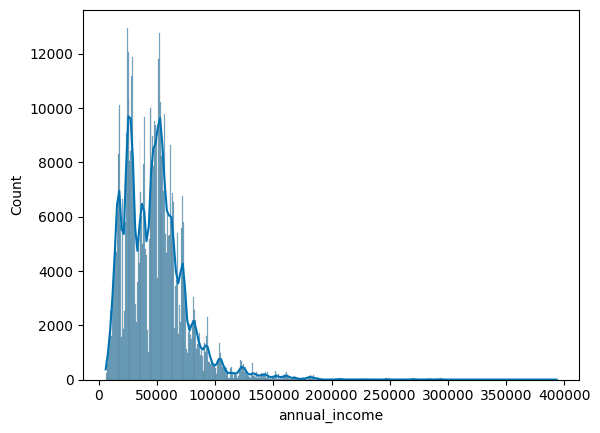

In [18]:
sns.histplot(train_df['annual_income'],kde=True)
plt.show()

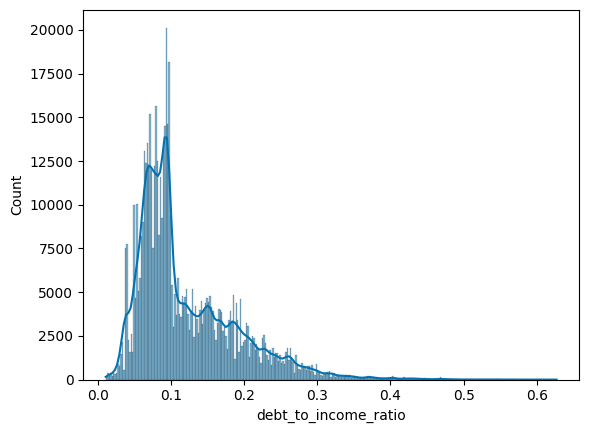

In [19]:
sns.histplot(train_df['debt_to_income_ratio'],kde=True)
plt.show()

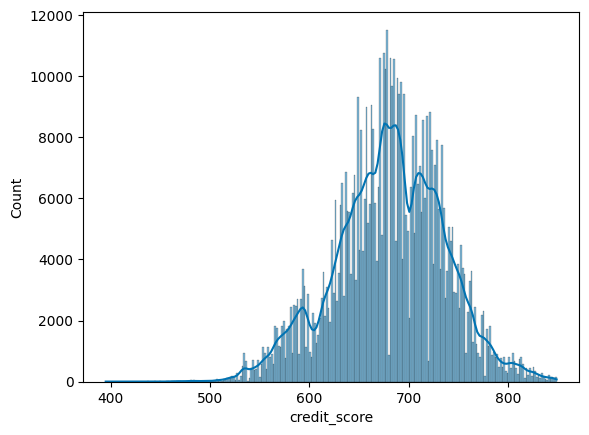

In [20]:
sns.histplot(train_df['credit_score'],kde=True)
plt.show()

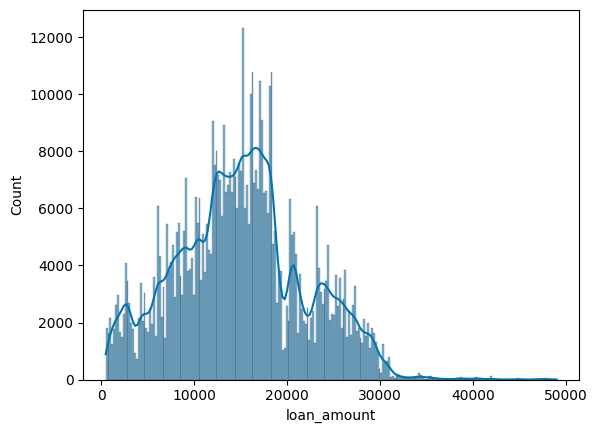

In [21]:
sns.histplot(train_df['loan_amount'],kde=True)
plt.show()

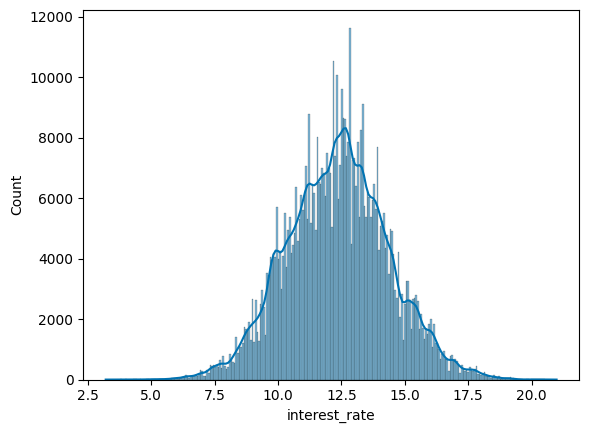

In [22]:
sns.histplot(train_df['interest_rate'],kde=True)
plt.show()

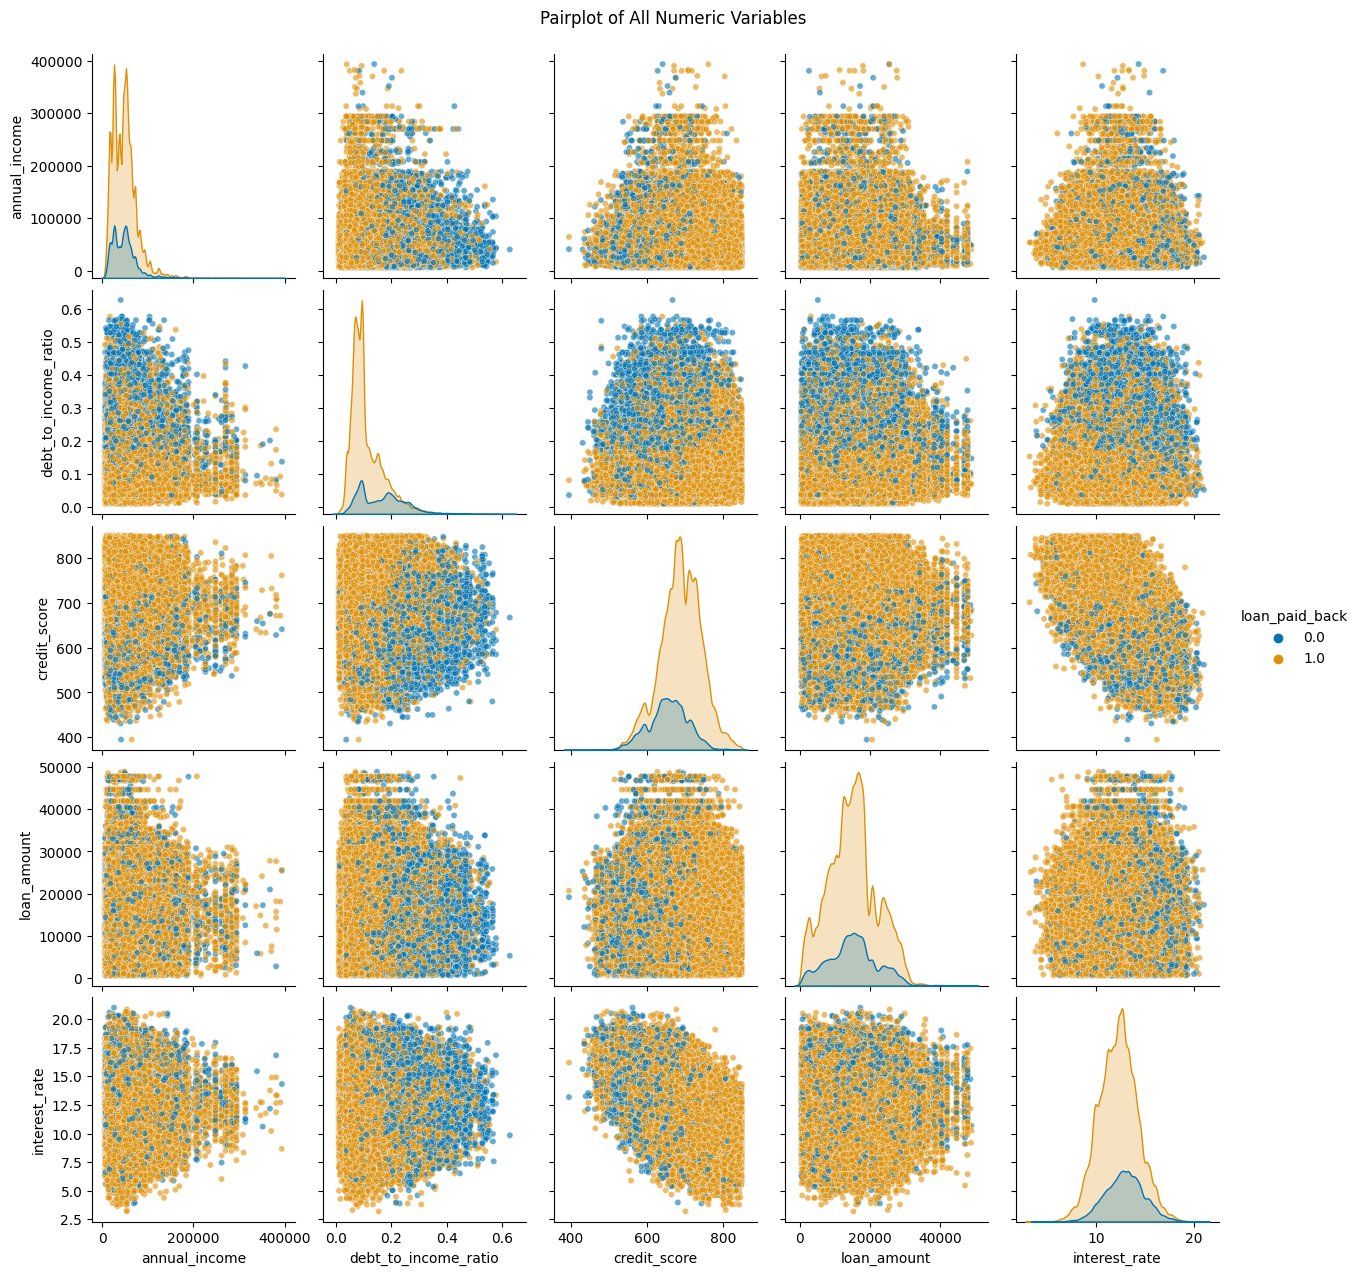

In [23]:
sns.pairplot(train_df, vars=num_cols[0:5], diag_kind='kde',hue="loan_paid_back", plot_kws={'alpha': 0.6, 's': 20})
plt.suptitle('Pairplot of All Numeric Variables', y=1.02)
plt.show()

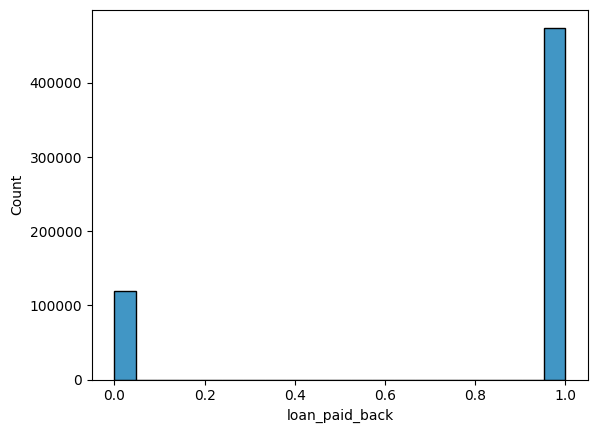

In [24]:
sns.histplot(train_df['loan_paid_back'])
plt.show()

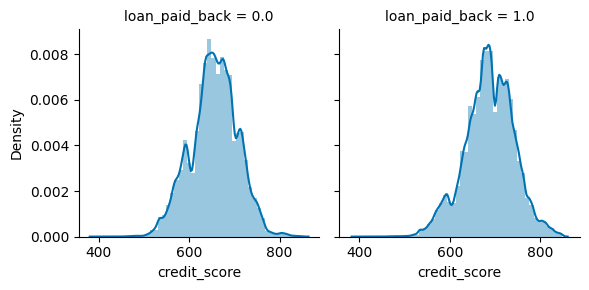

In [25]:
graph = sns.FacetGrid(train_df, col ='loan_paid_back') 
graph.map(sns.distplot, 'credit_score') 
plt.show()

In [26]:
train_df["gender"].value_counts() #categorical value

gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64

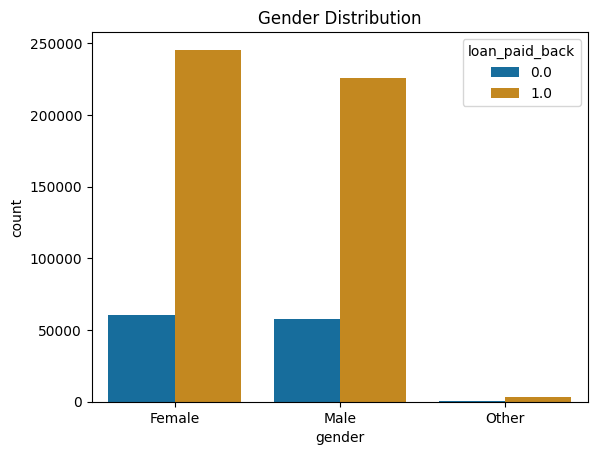

In [27]:
sns.countplot(data=train_df, x="gender", hue="loan_paid_back")
plt.title("Gender Distribution")
plt.show()

In [28]:
train_df["marital_status"].value_counts() #categorical value

marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64

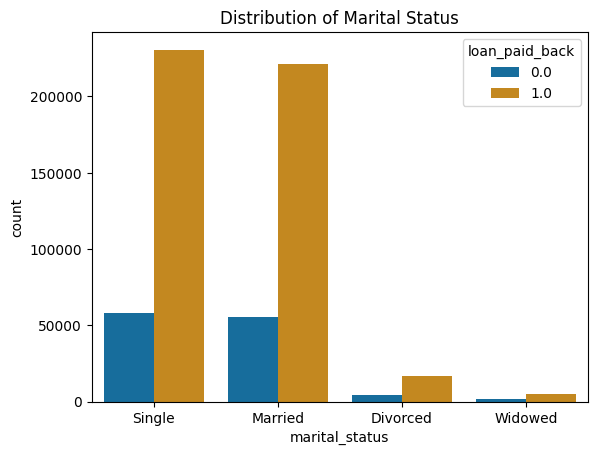

In [29]:
sns.countplot(data=train_df, x="marital_status", hue="loan_paid_back")
plt.title("Distribution of Marital Status")
plt.show()

In [30]:
train_df["education_level"].value_counts().sort_values() #categorical value

education_level
PhD             11022
Other           26677
Master's        93097
High School    183592
Bachelor's     279606
Name: count, dtype: int64

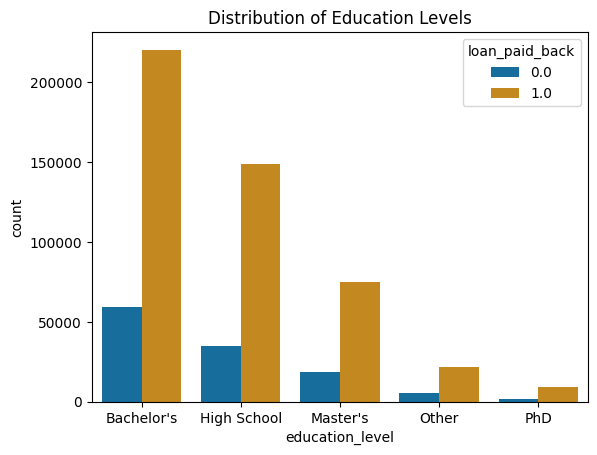

In [31]:
sns.countplot(data=train_df, x="education_level", order=train_df["education_level"].value_counts().sort_values(ascending=False).index, hue="loan_paid_back")
plt.title("Distribution of Education Levels")
plt.show()

In [32]:
train_df["employment_status"].value_counts().sort_values() #categorical value

employment_status
Student           11931
Retired           16453
Self-employed     52480
Unemployed        62485
Employed         450645
Name: count, dtype: int64

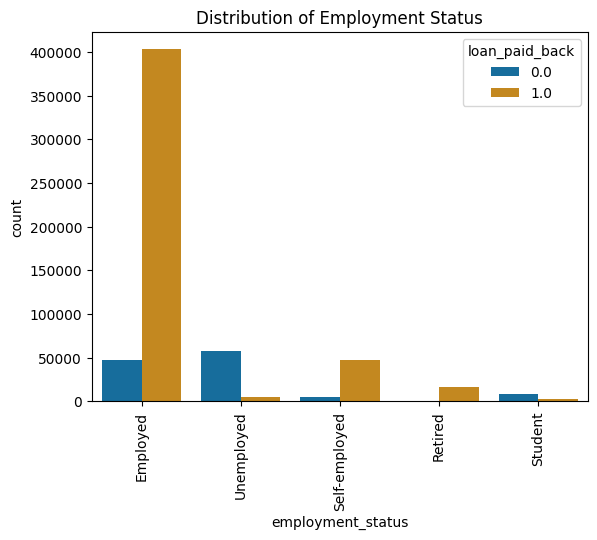

In [33]:
sns.countplot(data=train_df, x="employment_status", order=train_df["employment_status"].value_counts().sort_values(ascending=False).index, hue="loan_paid_back")
plt.title("Distribution of Employment Status")
plt.xticks(rotation=90)
plt.show()

In [34]:
train_df["loan_purpose"].value_counts().sort_values() #categorical value

loan_purpose
Vacation                8449
Medical                22806
Business               35303
Education              36641
Home                   44118
Car                    58108
Other                  63874
Debt consolidation    324695
Name: count, dtype: int64

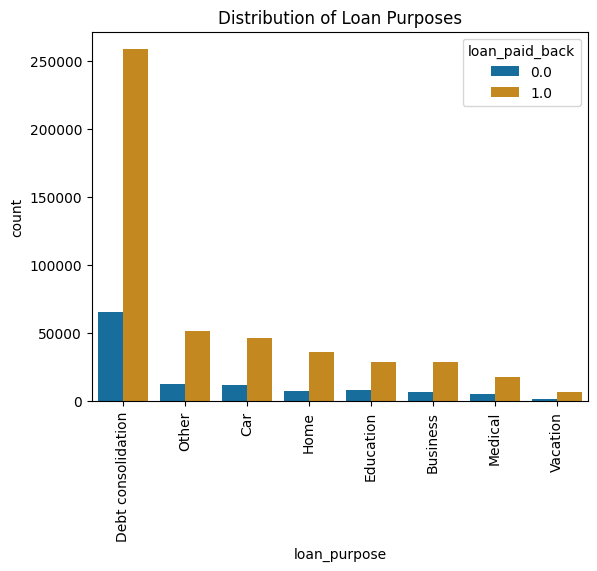

In [35]:
sns.countplot(data=train_df, x="loan_purpose", order=train_df["loan_purpose"].value_counts().sort_values(ascending=False).index, hue="loan_paid_back")
plt.title("Distribution of Loan Purposes")
plt.xticks(rotation=90)
plt.show()

In [36]:
train_df["grade_subgrade"].value_counts()

grade_subgrade
C3    58695
C4    55957
C2    54443
C1    53363
C5    53317
D1    37029
D3    36694
D4    35097
D2    34432
D5    32101
B2    15167
B1    14344
B5    13937
B3    13926
B4    13877
E4     8036
E3     7075
E1     6891
E2     6372
E5     6084
F5     5947
F4     5535
F1     5534
F2     5203
F3     5082
A5     2471
A3     2066
A2     2018
A4     1701
A1     1600
Name: count, dtype: int64

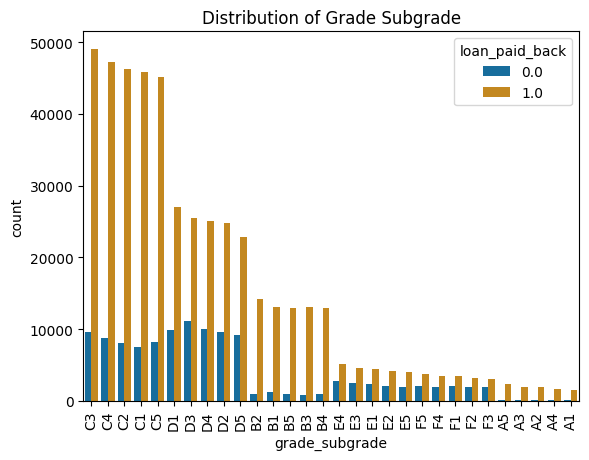

In [37]:
sns.countplot(data=train_df, x="grade_subgrade", order=train_df["grade_subgrade"].value_counts().sort_values(ascending=False).index, hue="loan_paid_back")
plt.title("Distribution of Grade Subgrade")
plt.xticks(rotation=90)
plt.show()

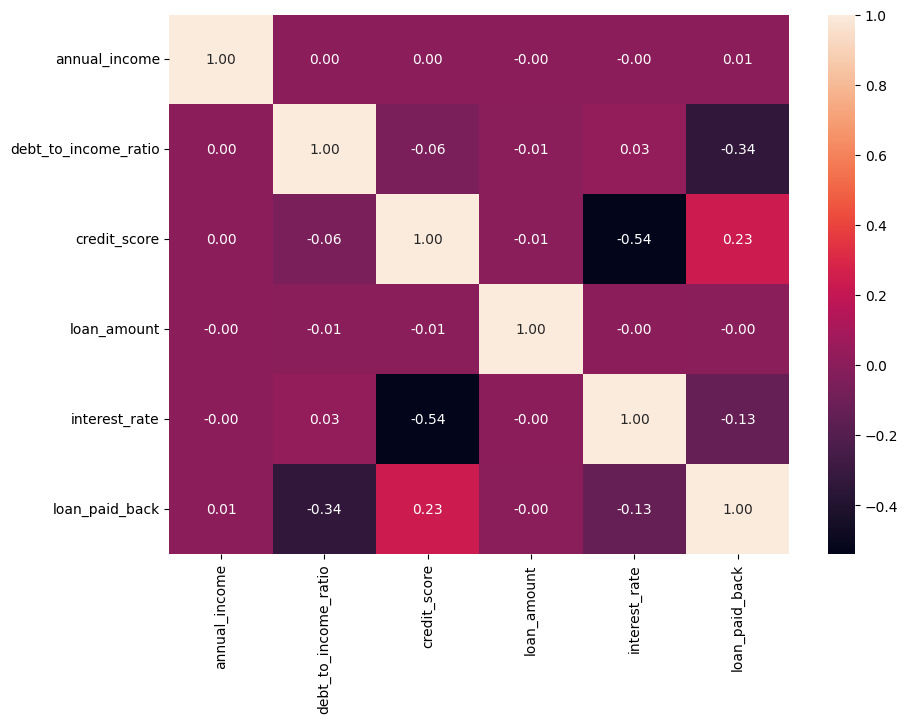

In [38]:
plt.figure(figsize=(10,7))
sns.heatmap(train_df[num_cols].corr(), annot=True, fmt=".2f")
plt.show()

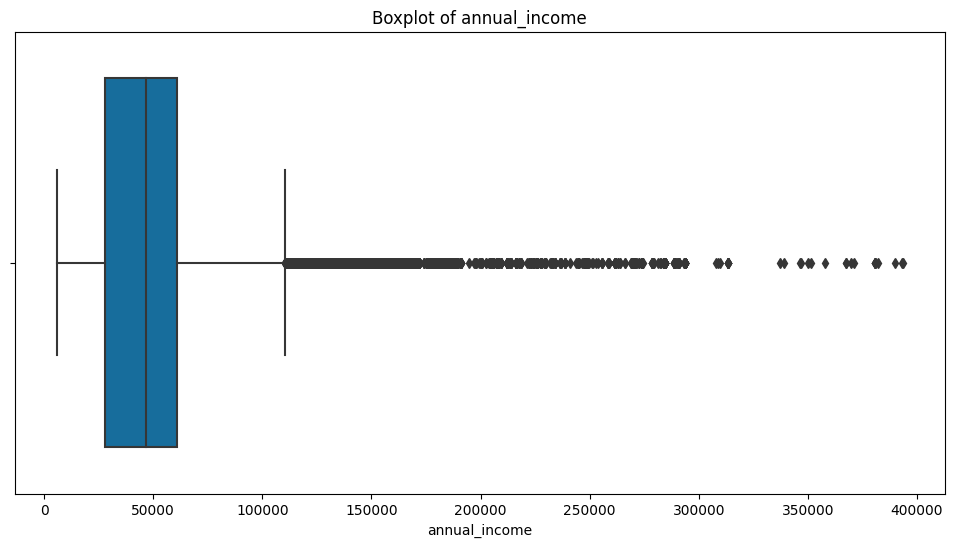

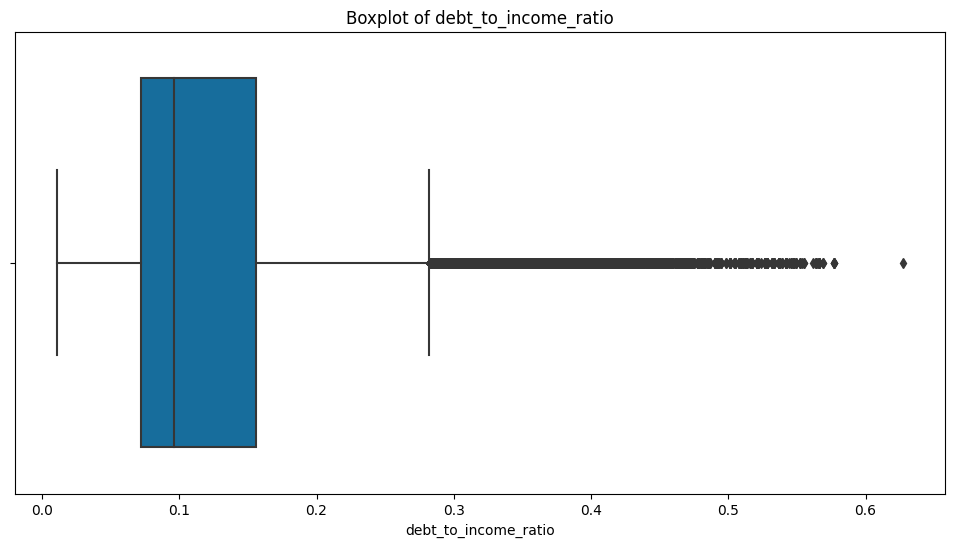

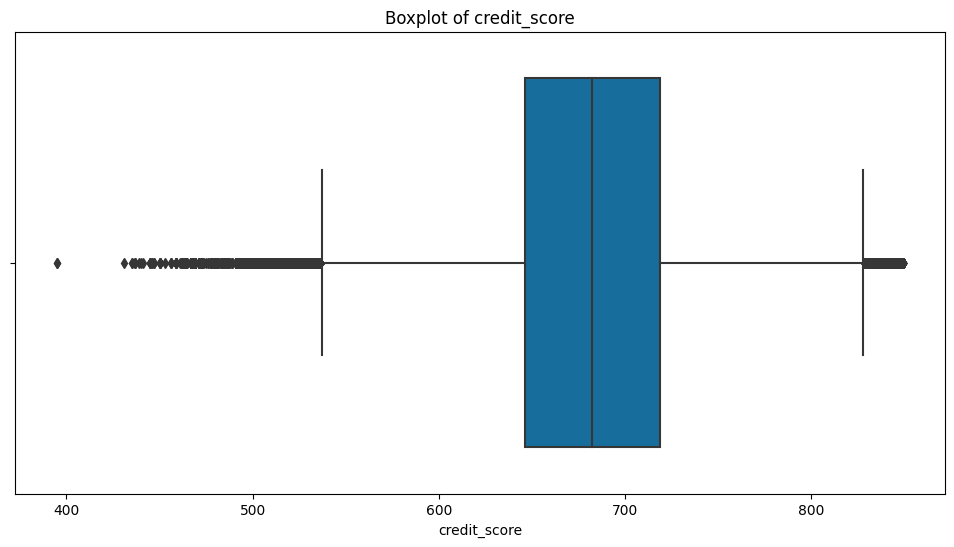

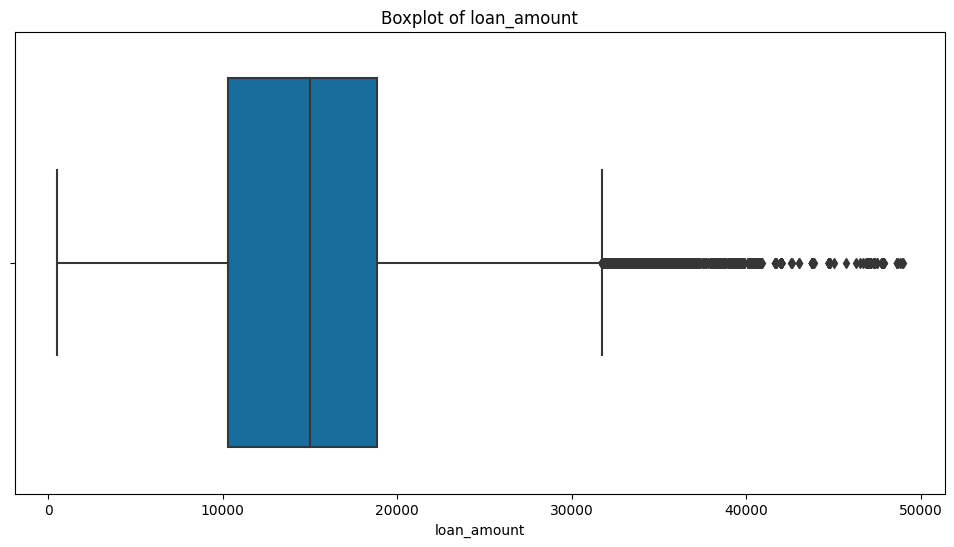

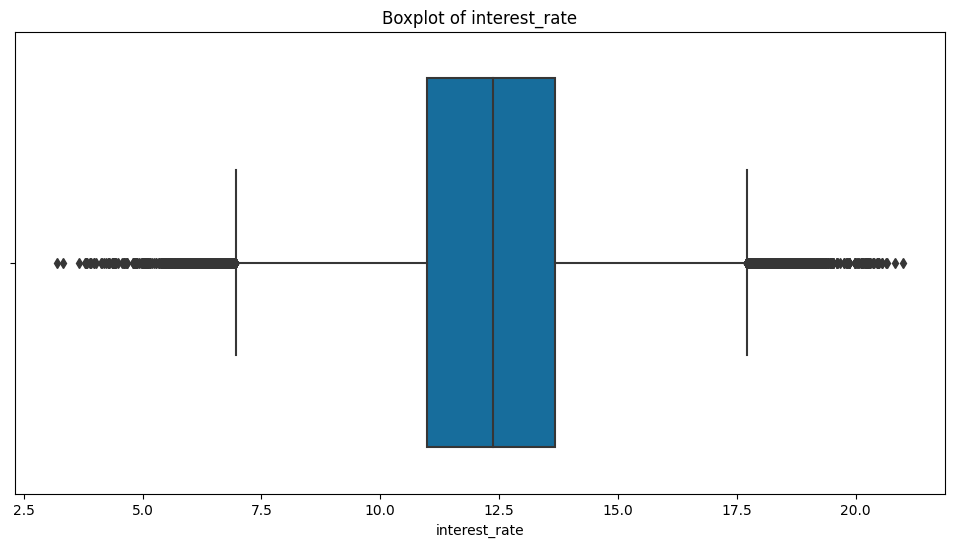

In [39]:
for col in num_cols[0:5]:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=train_df, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

# 6. Data Preprocessing

In [40]:
train_df["grade_subgrade"]=train_df["grade_subgrade"].str[0]
test_df["grade_subgrade"]=test_df["grade_subgrade"].str[0]

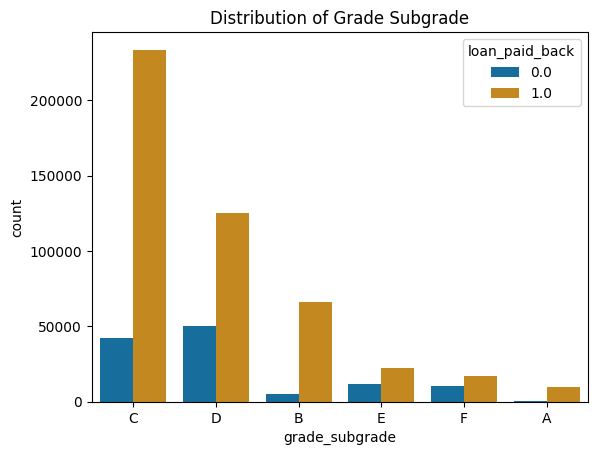

In [41]:
sns.countplot(data=train_df, x="grade_subgrade", order=train_df["grade_subgrade"].value_counts().sort_values(ascending=False).index, hue="loan_paid_back")
plt.title("Distribution of Grade Subgrade")
plt.show()

In [42]:
le=LabelEncoder()
for col in cat_cols:   
    train_df[col]=le.fit_transform(train_df[col])
    test_df[col]=le.transform(test_df[col])

In [43]:
train_df.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,0,2,1,2,6,2,1.0
1,22108.02,0.166,636,4593.10,12.92,1,1,2,0,2,3,0.0
2,49566.20,0.097,694,17005.15,9.76,1,2,1,0,2,2,1.0
3,46858.25,0.065,533,4682.48,16.10,0,2,1,0,2,5,1.0
4,25496.70,0.053,665,12184.43,10.21,1,1,1,0,6,3,1.0


In [44]:
test_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,0,2,1,0,6,3
1,593995,46626.39,0.093,732,15492.25,12.85,0,1,2,0,6,2
2,593996,54954.89,0.367,611,3796.41,13.29,1,2,0,0,2,3
3,593997,25644.63,0.110,671,6574.30,9.57,0,2,0,0,2,2
4,593998,25169.64,0.081,688,17696.89,12.80,0,1,4,0,0,2


In [45]:
scaler=StandardScaler()
train_df[num_cols[0:5]]=scaler.fit_transform(train_df[num_cols[0:5]])
test_df[num_cols[0:5]]=scaler.transform(test_df[num_cols[0:5]])

In [46]:
X=train_df.drop(columns=["loan_paid_back"])
y=train_df["loan_paid_back"]

In [47]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Modeling


In [48]:
logreg=LogisticRegression()
logreg.fit(X_train, y_train)
y_probs = logreg.predict_proba(X_test)[:, 1]
logreg_auc_score = round(roc_auc_score(y_test, y_probs),3)

In [49]:
print("AUC ROC for logistic regression model:",logreg_auc_score)

AUC ROC for logistic regression model: 0.892


In [50]:
catboost=CatBoostClassifier()
catboost.fit(X_train, y_train)
y_probs = catboost.predict_proba(X_test)[:, 1]
catboost_auc_score = round(roc_auc_score(y_test, y_probs),3)

Learning rate set to 0.143205
0:	learn: 0.5448928	total: 103ms	remaining: 1m 43s
1:	learn: 0.4449699	total: 148ms	remaining: 1m 13s
2:	learn: 0.3837815	total: 190ms	remaining: 1m 3s
3:	learn: 0.3450284	total: 234ms	remaining: 58.3s
4:	learn: 0.3196180	total: 278ms	remaining: 55.4s
5:	learn: 0.3009959	total: 322ms	remaining: 53.3s
6:	learn: 0.2888850	total: 365ms	remaining: 51.8s
7:	learn: 0.2800646	total: 411ms	remaining: 51s
8:	learn: 0.2741838	total: 455ms	remaining: 50.1s
9:	learn: 0.2701765	total: 499ms	remaining: 49.4s
10:	learn: 0.2670956	total: 545ms	remaining: 49s
11:	learn: 0.2651647	total: 591ms	remaining: 48.7s
12:	learn: 0.2625162	total: 634ms	remaining: 48.2s
13:	learn: 0.2610517	total: 676ms	remaining: 47.6s
14:	learn: 0.2601413	total: 723ms	remaining: 47.4s
15:	learn: 0.2593893	total: 765ms	remaining: 47.1s
16:	learn: 0.2589168	total: 809ms	remaining: 46.8s
17:	learn: 0.2578822	total: 859ms	remaining: 46.9s
18:	learn: 0.2574317	total: 906ms	remaining: 46.8s
19:	learn: 0.

In [51]:
print("AUC ROC for catboost model:",catboost_auc_score)

AUC ROC for catboost model: 0.924


In [52]:
lgbm=LGBMClassifier()
lgbm.fit(X_train, y_train)
y_probs = lgbm.predict_proba(X_test)[:, 1]
lgbm_auc_score = round(roc_auc_score(y_test, y_probs),2)

[LightGBM] [Info] Number of positive: 379692, number of negative: 95503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1305
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799024 -> initscore=1.380203
[LightGBM] [Info] Start training from score 1.380203


In [53]:
print("AUC ROC for lightGBM classifier model:",lgbm_auc_score)

AUC ROC for lightGBM classifier model: 0.92


In [54]:
xgb=XGBClassifier()
xgb.fit(X_train, y_train)
y_probs = xgb.predict_proba(X_test)[:, 1]
xgb_auc_score = round(roc_auc_score(y_test, y_probs),3)

In [55]:
print("AUC ROC for XGBoost classifier model:",xgb_auc_score)

AUC ROC for XGBoost classifier model: 0.921


In [56]:
rfc=RandomForestClassifier()
rfc.fit(X_train, y_train)
y_probs = rfc.predict_proba(X_test)[:, 1]
rfc_auc_score = round(roc_auc_score(y_test, y_probs),3)

In [57]:
print("AUC ROC for random forest model:",rfc_auc_score)

AUC ROC for random forest model: 0.909


In [58]:
ensemble=StackingClassifier(
    estimators=[("catboost",catboost),
                ("lgbm",lgbm),
                ("xgb",xgb),
                ("rfc",rfc)],
    final_estimator=LogisticRegression(),
    stack_method="predict_proba",
    cv=5)

In [59]:
ensemble.fit(X_train, y_train)

Learning rate set to 0.143205
0:	learn: 0.5448928	total: 51.5ms	remaining: 51.5s
1:	learn: 0.4449699	total: 96.5ms	remaining: 48.2s
2:	learn: 0.3837815	total: 139ms	remaining: 46.2s
3:	learn: 0.3450284	total: 183ms	remaining: 45.7s
4:	learn: 0.3196180	total: 226ms	remaining: 45s
5:	learn: 0.3009959	total: 269ms	remaining: 44.6s
6:	learn: 0.2888850	total: 310ms	remaining: 44s
7:	learn: 0.2800646	total: 357ms	remaining: 44.3s
8:	learn: 0.2741838	total: 401ms	remaining: 44.2s
9:	learn: 0.2701765	total: 443ms	remaining: 43.9s
10:	learn: 0.2670956	total: 488ms	remaining: 43.8s
11:	learn: 0.2651647	total: 533ms	remaining: 43.9s
12:	learn: 0.2625162	total: 574ms	remaining: 43.5s
13:	learn: 0.2610517	total: 615ms	remaining: 43.3s
14:	learn: 0.2601413	total: 662ms	remaining: 43.5s
15:	learn: 0.2593893	total: 705ms	remaining: 43.3s
16:	learn: 0.2589168	total: 748ms	remaining: 43.2s
17:	learn: 0.2578822	total: 792ms	remaining: 43.2s
18:	learn: 0.2574317	total: 840ms	remaining: 43.4s
19:	learn: 0.

StackingClassifier(cv=5,
                   estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7c472a09bd50>),
                               ('lgbm', LGBMClassifier()),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              featu...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('rfc', RandomForestClassifier())],
                   final_estimator=LogisticRegression(),
                   stack_method='predict_proba')

In [60]:
y_pred = ensemble.predict(X_test)
print(f"VotingClassifier Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"ROC AUC Score: {round(roc_auc_score(y_test, y_pred),3)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

VotingClassifier Accuracy: 0.906
ROC AUC Score: 0.806
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.86      0.64      0.73     23997
         1.0       0.91      0.97      0.94     94802

    accuracy                           0.91    118799
   macro avg       0.89      0.81      0.84    118799
weighted avg       0.90      0.91      0.90    118799



In [61]:
models = ["logreg","catboost","lgbm","xgb","rfc","stacked_models"]
auc_roc= [logreg_auc_score, catboost_auc_score, lgbm_auc_score, xgb_auc_score, rfc_auc_score, round(roc_auc_score(y_test, y_pred),3)]

In [62]:
model_auc_roc = pd.DataFrame({"Model": models, "AUC_ROC": auc_roc})
model_auc_roc.sort_values("AUC_ROC",ignore_index=True)

,Model,AUC_ROC
0,stacked_models,0.806
1,logreg,0.892
2,rfc,0.909
3,lgbm,0.920
4,xgb,0.921
5,catboost,0.924


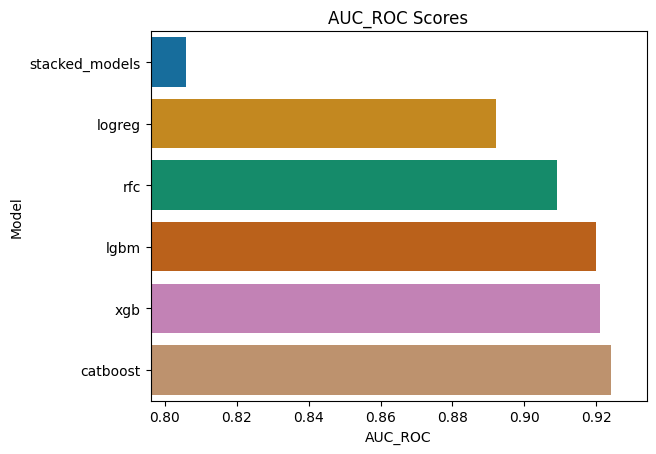

In [63]:
sns.barplot(x="AUC_ROC",y="Model",data=model_auc_roc.sort_values(by="AUC_ROC"))
plt.xlim(min(auc_roc)-0.01, max(auc_roc)+0.01) 
plt.ylabel("Model")
plt.title("AUC_ROC Scores")
plt.show()

# 8. Hyperparameters Tuning & Optimisation

In [64]:
catboost=CatBoostClassifier(verbose=0, random_state=42)
catboost_params = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.5),
    'iterations': randint(300, 900),
    'l2_leaf_reg': uniform(1, 10)
}

catboost_search = RandomizedSearchCV(
    catboost, catboost_params, n_iter=20, scoring='roc_auc',cv=5, 
    n_jobs=-1, random_state=42, verbose=1
)

In [65]:
catboost_search.fit(X_train, y_train)
best_catboost = catboost_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [66]:
y_probs = best_catboost.predict_proba(X_test)[:, 1]
catboost_auc_score = round(roc_auc_score(y_test, y_probs),3)
print("AUC ROC for best catboost model:",catboost_auc_score)

AUC ROC for best catboost model: 0.924


In [67]:
lgbm = LGBMClassifier(
    verbose=-1,
    allow_writing_files=False,
    random_state=42
)

lgbm_params = {
    'n_estimators': randint(200, 900),
    'num_leaves': randint(20, 150),
    'max_depth': randint(-1, 15),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

lgbm_search = RandomizedSearchCV(
    lgbm, lgbm_params, n_iter=20, scoring='roc_auc', cv=5,
    n_jobs=-1, random_state=42, verbose=1
)


In [68]:
lgbm_search.fit(X_train, y_train)
best_lgbm = lgbm_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [69]:
y_probs = best_lgbm.predict_proba(X_test)[:, 1]
lgbm_auc_score = round(roc_auc_score(y_test, y_probs),3)
print("AUC ROC for best lgbm model:",lgbm_auc_score)

AUC ROC for best lgbm model: 0.923


In [70]:
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    verbosity=0,
    random_state=42
)

xgb_params = {
    'n_estimators': randint(200, 900),
    'max_depth': randint(3, 30),
    'learning_rate': uniform(0.01, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5)
}

xgb_search = RandomizedSearchCV(
    xgb, xgb_params, n_iter=20, scoring='roc_auc', cv=5,
    n_jobs=-1, random_state=42, verbose=1
)

In [71]:
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [72]:
y_probs = best_xgb.predict_proba(X_test)[:, 1]
xgb_auc_score = round(roc_auc_score(y_test, y_probs),3)
print("AUC ROC for best xgb model:",xgb_auc_score)

AUC ROC for best xgb model: 0.922


In [73]:
rfc = RandomForestClassifier()
rfc_params = {
    'n_estimators': randint(100, 600),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}

rfc_search = RandomizedSearchCV(
    rfc, rfc_params, n_iter=20, scoring='roc_auc', cv=5,
    n_jobs=-1, random_state=42, verbose=1
)

In [74]:
rfc_search.fit(X_train, y_train)
best_rfc = rfc_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [75]:
y_probs = best_rfc.predict_proba(X_test)[:, 1]
rfc_auc_score = round(roc_auc_score(y_test, y_probs),3)
print("AUC ROC for best xgb model:",rfc_auc_score)

AUC ROC for best xgb model: 0.916


In [76]:
ensemble=StackingClassifier(
    estimators=[("catboost",best_catboost),
                ("lgbm",best_lgbm),
                ("xgb",best_xgb),
                ("rfc",best_rfc)],
    final_estimator=LogisticRegression(),
    stack_method="predict_proba",
    cv=5
)

In [77]:
ensemble.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7c472ef2e090>),
                               ('lgbm',
                                LGBMClassifier(allow_writing_files=False,
                                               colsample_bytree=0.9140703845572055,
                                               learning_rate=0.10983689107917986,
                                               max_depth=5, n_estimators=443,
                                               num_leaves=83, random_state=42,
                                               subsample=0.786705157299192,
                                               verbose=-1)),
                               ('xgb',
                                XGBClassifier(base...
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=812, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('rfc',
                                RandomForestClassifier(max_depth=14,
                                                       max_features=None,
                                                       min_samples_leaf=4,
                                                       min_samples_split=9,
                                                       n_estimators=230))],
                   final_estimator=LogisticRegression(),
                   stack_method='predict_proba')

In [78]:
y_pred = ensemble.predict(X_test)
print(f"VotingClassifier Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"ROC AUC Score: {round(roc_auc_score(y_test, y_pred),3)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

VotingClassifier Accuracy: 0.906
ROC AUC Score: 0.806
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.86      0.64      0.73     23997
         1.0       0.91      0.97      0.94     94802

    accuracy                           0.91    118799
   macro avg       0.89      0.81      0.84    118799
weighted avg       0.90      0.91      0.90    118799



# 9. Submitting Predictions


In [79]:
y_pred=ensemble.predict(test_df.drop(columns=['id']))

In [80]:
submission = pd.DataFrame({'id': test_df['id'], 'loan_paid_back': y_pred})
submission.to_csv('submission.csv', index=False)
print("Submission file saved")
display(submission.head())

Submission file saved


,id,loan_paid_back
0,593994,1.0
1,593995,1.0
2,593996,0.0
3,593997,1.0
4,593998,1.0
